LightGBM

Generalized Additive Models (GAM) 

Convolutional Neural Networks (CNN) 

Long Short-Term Memory Networks (LSTM) 

Transformer-based Models

Wavenet

InceptionTime

In [1]:
import pandas as pd


In [2]:
df = pd.read_csv('./solar_weather_processed.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196776 entries, 0 to 196775
Data columns (total 18 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Energy delta_Wh  196776 non-null  int64  
 1   GHI              196776 non-null  float64
 2   temp             196776 non-null  float64
 3   pressure         196776 non-null  float64
 4   humidity         196776 non-null  float64
 5   wind_speed       196776 non-null  float64
 6   rain_1h          196776 non-null  float64
 7   clouds_all       196776 non-null  float64
 8   Year             196776 non-null  int64  
 9   Month_num        196776 non-null  int64  
 10  DayOfYear        196776 non-null  int64  
 11  Minute           196776 non-null  int64  
 12  Hour             196776 non-null  int64  
 13  Season           196776 non-null  int64  
 14  Day              196776 non-null  int64  
 15  Week_cos         196776 non-null  float64
 16  Energy_lag_1     196776 non-null  floa

In [4]:
df['Energy delta_Wh'].describe()

count    196776.00000
mean        573.00310
std        1044.82681
min           0.00000
25%           0.00000
50%           0.00000
75%         577.00000
max        5020.00000
Name: Energy delta_Wh, dtype: float64

In [5]:
df.head()

,Energy delta_Wh,GHI,temp,pressure,humidity,wind_speed,rain_1h,clouds_all,Year,Month_num,DayOfYear,Minute,Hour,Season,Day,Week_cos,Energy_lag_1,Energy_lag_2
0,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,0,0,3,6,0.992981,0.0,0.0
1,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,15,0,3,6,0.992981,0.0,0.0
2,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,30,0,3,6,0.992981,0.0,0.0
3,0,0.0,1.6,1021.0,100.0,4.9,0.0,100.0,2017,1,1,45,0,3,6,0.992981,0.0,0.0
4,0,0.0,1.7,1020.0,100.0,5.2,0.0,100.0,2017,1,1,0,1,3,6,0.992981,0.0,0.0


## Forward Feature Selection

In [6]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from lightgbm import LGBMRegressor
# from sklearn.feature_selection import SequentialFeatureSelector
# from sklearn.model_selection import TimeSeriesSplit

# # Assume df is your DataFrame
# target_col = "Energy delta_Wh"
# X = df.drop(columns=[target_col])
# y = df[target_col]

# # Use TimeSeriesSplit to respect the order in time-series data
# tscv = TimeSeriesSplit(n_splits=3)

# # Initialize the LightGBM regressor (using GPU if available)
# model = LGBMRegressor(random_state=42, device='gpu')

# # Perform forward feature selection to select (for example) 10 features.
# # Adjust n_features_to_select as needed.
# sfs = SequentialFeatureSelector(
#     model,
#     n_features_to_select=10,
#     direction='forward',
#     cv=tscv,
#     scoring='neg_root_mean_squared_error',
#     n_jobs=-1
# )
# sfs.fit(X, y)

# # Retrieve the selected features
# selected_features = X.columns[sfs.get_support()]
# print("Selected features:", list(selected_features))

# # Train the model using only the selected features
# X_selected = X[selected_features]
# model.fit(X_selected, y)

# # Get the built-in feature importance from LightGBM
# importances = model.feature_importances_
# importance_df = pd.DataFrame({
#     'Feature': selected_features,
#     'Importance': importances
# }).sort_values(by='Importance', ascending=False)

# # Display the feature importance table
# print("\nFeature Contribution Table:")
# print(importance_df)

# # Plot the feature importance as a bar chart
# plt.figure(figsize=(10, 6))
# plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
# plt.xlabel("Feature Importance")
# plt.title("Feature Contribution to Model Prediction")
# plt.gca().invert_yaxis()  # Show highest importance on top
# plt.show()


In [7]:
# # Define the list of features based on the feature contribution table
# selected_features = [
#     "GHI", "Energy_lag_1", "Energy_lag_2", "Hour", 
#     "DayOfYear", "Week_cos", "clouds_all", "Year", 
#     "Minute", "rain_1h"
# ]

# # Option 1: Filter to keep only the selected features
# # df_filtered = df[selected_features]

# # Option 2: If you want to keep the target column as well, include it:
# df = df[selected_features + ["Energy delta_Wh"]]

# # Display the first few rows of the filtered DataFrame
# print(df.head())


# Seperate file for model buiding only


In [8]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor, record_evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [9]:
FEATURES = [col for col in df.columns if col != 'Energy delta_Wh']
X = df[FEATURES]
y = df['Energy delta_Wh']

In [10]:
# 7. Time-based train-test split (70-30)
train_size = int(len(df) * 0.7)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

In [11]:
# Initialize scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1))



In [12]:
# Helper function for RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Models

## lightGBM

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt
# from lightgbm import LGBMRegressor, record_evaluation
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# # Initialize LightGBM model
# model = LGBMRegressor(
#     n_estimators=500,
#     learning_rate=0.01,
#     max_depth=6,
#     num_leaves=64,         
#     bagging_fraction=0.8,  
#     feature_fraction=0.8,  
#     lambda_l1=0.1,         
#     lambda_l2=0.1,         
#     random_state=42,
# )

# evals_result = {}

# # Train the model with scaled data
# model.fit(
#     X_train_scaled, y_train_scaled.ravel(),  # Ensure y is 1D
#     eval_set=[(X_train_scaled, y_train_scaled.ravel()), (X_test_scaled, y_test_scaled.ravel())],
#     eval_metric='rmse',
#     callbacks=[record_evaluation(evals_result)]
# )

# # Predict with scaled data
# y_pred_scaled = model.predict(X_test_scaled)

# # Convert predictions back to original scale
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# # Calculate performance metrics using original values
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("MAE:", mae)
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("R^2:", r2)

# # Correct key names
# train_rmse_scaled = np.array(evals_result["valid_0"]["rmse"]).reshape(-1, 1)
# valid_rmse_scaled = np.array(evals_result["valid_1"]["rmse"]).reshape(-1, 1)

# train_rmse = scaler_y.inverse_transform(train_rmse_scaled).flatten()
# valid_rmse = scaler_y.inverse_transform(valid_rmse_scaled).flatten()

# # Plot the RMSE curve using original values
# plt.figure(figsize=(10, 5))
# plt.plot(train_rmse, label="Training RMSE")
# plt.plot(valid_rmse, label="Validation RMSE")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("LightGBM Model")
# plt.legend()
# plt.show()


In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# from lightgbm import LGBMRegressor, record_evaluation
# from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Initialize scalers
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # Scale the features and target
# X_train_scaled = scaler_x.fit_transform(X_train)
# X_test_scaled = scaler_x.transform(X_test)
# y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
# y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

# # Define parameter grid
# param_grid = {
#     'n_estimators': [500, 1000],
#     'learning_rate': [0.01, 0.05],
#     'max_depth': [6, 8],
#     'num_leaves': [64, 128],    
#     'bagging_fraction': [0.8, 1.0],
#     'feature_fraction': [0.8, 1.0],
#     'lambda_l1': [0.0, 0.1],
#     'lambda_l2': [0.0, 0.1]
# }

# # Use TimeSeriesSplit
# tscv = TimeSeriesSplit(n_splits=2)

# # Initialize LightGBM model
# model = LGBMRegressor(random_state=42)

# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_root_mean_squared_error',  # Negative RMSE
#     cv=tscv,
#     verbose=1,
#     n_jobs=2  # Limit parallelism
# )

# # Fit GridSearchCV on scaled training data
# grid_search.fit(X_train_scaled, y_train_scaled)

# # Best parameters and best RMSE (scaled)
# print("Best Parameters (Grid Search):", grid_search.best_params_)
# print("Best RMSE (CV) [Scaled]:", -grid_search.best_score_)

# # Retrieve best model
# best_model = grid_search.best_estimator_

# # Display best model parameters
# print("\nAll Best Model Hyperparameters:")
# for param, value in best_model.get_params().items():
#     print(f"{param}: {value}")

# # Train the best model again to record evaluation results
# evals_result = {}
# best_model.fit(
#     X_train_scaled, y_train_scaled,
#     eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
#     eval_metric='rmse',
#     callbacks=[record_evaluation(evals_result)]
# )

# # Predict with scaled data
# y_pred_scaled = best_model.predict(X_test_scaled)

# # Convert predictions back to original scale
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# # Evaluate using original scale
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("\nTest MAE:", mae)
# print("Test MSE:", mse)
# print("Test RMSE:", rmse)
# print("R^2:", r2)



#### Best Model

In [15]:
# import numpy as np
# import matplotlib.pyplot as plt
# from lightgbm import LGBMRegressor, record_evaluation
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# # Initialize scalers
# scaler_x = MinMaxScaler()
# scaler_y = MinMaxScaler()

# # Scale the features and target
# X_train_scaled = scaler_x.fit_transform(X_train)
# X_test_scaled = scaler_x.transform(X_test)
# y_train_scaled = scaler_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).flatten()
# y_test_scaled = scaler_y.transform(y_test.to_numpy().reshape(-1, 1)).flatten()

# # Best parameters from Grid Search
# model = LGBMRegressor(
#     n_estimators=500,
#     learning_rate=0.01,
#     max_depth=8,
#     num_leaves=64,    
#     bagging_fraction=0.8,
#     feature_fraction=0.8,
#     lambda_l1=0.1,
#     lambda_l2=0.0,
#     random_state=42,
# )

# # Dictionary to store training history
# evals_result = {}

# # Fit the model on the scaled training data
# model.fit(
#     X_train_scaled, y_train_scaled,
#     eval_set=[(X_train_scaled, y_train_scaled), (X_test_scaled, y_test_scaled)],
#     eval_metric='rmse',
#     callbacks=[record_evaluation(evals_result)]
# )

# # Predict on the scaled test set
# y_pred_scaled = model.predict(X_test_scaled)

# # Convert predictions back to original scale
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# # Evaluate the model using original scale
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print("MAE:", mae)
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("R^2:", r2)

# # Convert RMSE values for plotting
# train_rmse_scaled = np.array(evals_result["training"]["rmse"]).reshape(-1, 1)
# valid_rmse_scaled = np.array(evals_result["valid_1"]["rmse"]).reshape(-1, 1)

# # Inverse transform to original scale
# train_rmse = scaler_y.inverse_transform(train_rmse_scaled).flatten()
# valid_rmse = scaler_y.inverse_transform(valid_rmse_scaled).flatten()

# # Plot RMSE curve in original values
# plt.figure(figsize=(10, 5))
# plt.plot(train_rmse, label="Training RMSE (Original Scale)")
# plt.plot(valid_rmse, label="Validation RMSE (Original Scale)")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("LightGBM Model with Scaled Data (Rescaled to Original Values)")
# plt.legend()
# plt.show()

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 5))
# plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
# plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
# plt.xlabel('Time / Index')
# plt.ylabel('Energy delta_Wh')
# plt.title('Actual vs Predicted Energy Consumption')
# plt.legend()
# plt.show()


## GAM

In [16]:
# from pygam import ExpectileGAM, s

# gam = ExpectileGAM(
#     # define smooth terms for each of your 17 features (0..16)
#     s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9)
#     + s(10) + s(11) + s(12) + s(13) + s(14) + s(15) + s(16)
# ).fit(X, y)


# # Print model summary to see the final chosen hyperparameters and significance of terms
# print(gam.summary())


In [17]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error

# # Predict on test set
# y_pred = gam.predict(X_test)

# # Compute accuracy metrics
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("MAE:", mae)
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("R^2:", r2)

# # Plot the training vs. validation RMSE
# plt.figure(figsize=(10, 5))
# plt.plot(evals_result["training"]["rmse"], label="Training RMSE")
# plt.plot(evals_result["valid_1"]["rmse"], label="Validation RMSE")
# plt.xlabel("Iterations")
# plt.ylabel("RMSE")
# plt.title("LightGBM Model with Best Grid Search Parameters")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))
# plt.plot(y_test.index, y_test, label='Actual', alpha=0.7)
# plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
# plt.xlabel('Time / Index')
# plt.ylabel('Energy delta_Wh')
# plt.title('Actual vs Predicted Energy Consumption')
# plt.legend()
# plt.show()


## CNN

### Set up the CNN requirements

In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense, SpatialDropout1D, BatchNormalization, Dropout)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import keras_tuner as kt

# Sequence Creation with Striding
TIME_STEPS = 24  # 24 hours in 15-minute intervals

SEQ_STRIDE = 2


def create_sequences(X, y, time_steps, stride=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, stride):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, TIME_STEPS, SEQ_STRIDE)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, TIME_STEPS, SEQ_STRIDE)

### CNN Base Model 

Epoch 1/100
1076/1076 [==============================] - 11s 8ms/step - loss: 0.0386 - mae: 0.0818 - val_loss: 0.0240 - val_mae: 0.0477
Epoch 2/100
1076/1076 [==============================] - 8s 7ms/step - loss: 0.0243 - mae: 0.0542 - val_loss: 0.0195 - val_mae: 0.0475
Epoch 3/100
1076/1076 [==============================] - 8s 7ms/step - loss: 0.0193 - mae: 0.0497 - val_loss: 0.0171 - val_mae: 0.0448
Epoch 4/100
1076/1076 [==============================] - 8s 7ms/step - loss: 0.0155 - mae: 0.0474 - val_loss: 0.0136 - val_mae: 0.0459
Epoch 5/100
1076/1076 [==============================] - 8s 7ms/step - loss: 0.0128 - mae: 0.0454 - val_loss: 0.0105 - val_mae: 0.0397
Epoch 6/100
1076/1076 [==============================] - 8s 8ms/step - loss: 0.0110 - mae: 0.0445 - val_loss: 0.0098 - val_mae: 0.0398
Epoch 7/100
1076/1076 [==============================] - 9s 9ms/step - loss: 0.0096 - mae: 0.0432 - val_loss: 0.0086 - val_mae: 0.0397
Epoch 8/100
1076/1076 [==============================]

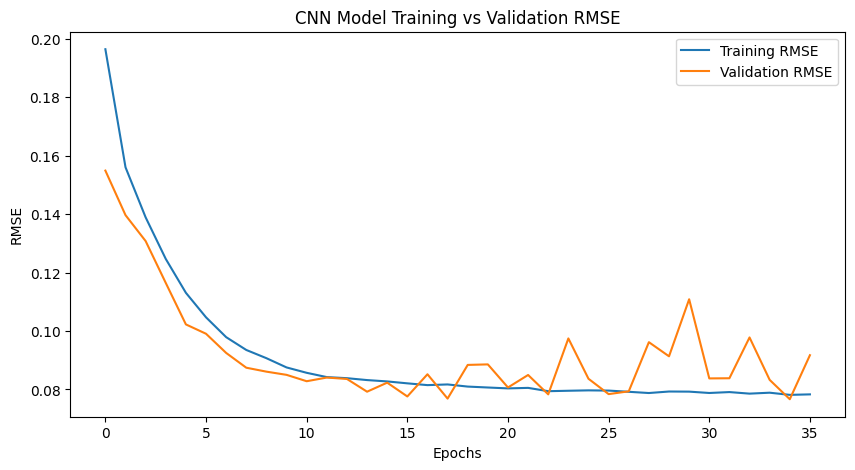

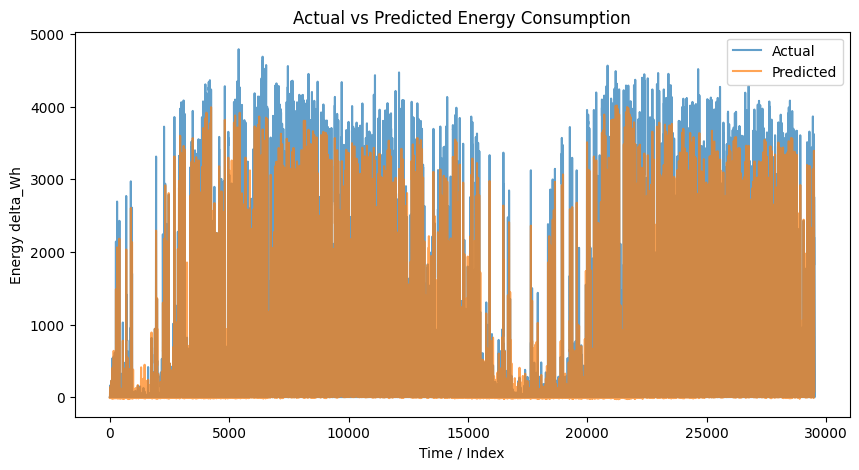

In [ ]:
#   Memory-Optimized Model Architecture
model = Sequential([
    # First Conv Block with Large Context
    Conv1D(32, 9, activation='relu', padding='causal',
           dilation_rate=1, kernel_regularizer=l2(1e-4),
           input_shape=(TIME_STEPS, X_train.shape[1])),
    MaxPooling1D(2),
    BatchNormalization(),
    SpatialDropout1D(0.2),
    
    # Second Conv Block with Medium Context
    Conv1D(64, 5, activation='relu', padding='causal',
           dilation_rate=3, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    SpatialDropout1D(0.3),
    
    # Third Conv Block with Local Context
    Conv1D(128, 3, activation='relu', padding='causal',
           dilation_rate=6, kernel_regularizer=l2(1e-4)),
    GlobalAveragePooling1D(),
    
    # Final Dense Layers
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(1)
])

optimizer = Adam(learning_rate=3e-4, clipnorm=0.5)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

callbacks = [
    EarlyStopping(patience=20, monitor='val_mae', restore_best_weights=True),
    TerminateOnNaN()
]

#   Memory-Efficient Training
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=callbacks,
    verbose=1
)

#   Make Predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

#   Evaluate
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

#   Plot Training vs. Validation RMSE over epochs
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("CNN Model Training vs Validation RMSE")
plt.legend()
plt.show()

#   Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()


### Hyperparameter for CNN

In [20]:
# # Define the model-building function with hyperparameters
# def build_model(hp):
#     conv_layers = hp.Choice('conv_layers', values=[2, 3]) 
#     filters_base = hp.Choice('filters_base', values=[32, 64])  
#     kernel_size_first = hp.Choice('kernel_size_first', values=[3, 5])  
#     dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3]) 
#     dense_units = hp.Choice('dense_units', values=[64, 128])  
#     learning_rate = hp.Choice('learning_rate', values=[1e-4, 3e-4]) 
#     l2_reg = hp.Choice('l2_reg', values=[1e-5, 1e-4])  

#     # Build model
#     model = Sequential()
    
#     # First Conv Block with Large Context
#     model.add(Conv1D(filters=filters_base, 
#                      kernel_size=kernel_size_first, 
#                      activation='relu', 
#                      padding='causal',
#                      dilation_rate=1, 
#                      kernel_regularizer=l2(l2_reg),
#                      input_shape=(TIME_STEPS, X_train.shape[1])))
#     model.add(MaxPooling1D(2))
#     model.add(BatchNormalization())
#     model.add(SpatialDropout1D(0.2))
    
#     # Add additional Conv blocks based on hyperparameter
#     for i in range(conv_layers - 1):
#         # Increase filters with depth
#         current_filters = filters_base * (2**(i+1))
#         current_kernel = max(3, kernel_size_first - (i*2))  # Decrease kernel size with depth
        
#         model.add(Conv1D(current_filters, 
#                          current_kernel, 
#                          activation='relu', 
#                          padding='causal',
#                          dilation_rate=3, 
#                          kernel_regularizer=l2(l2_reg)))
#         model.add(BatchNormalization())
#         model.add(SpatialDropout1D(0.3))
    
#     # Global pooling to reduce dimensionality
#     model.add(GlobalAveragePooling1D())
    
#     # Dense layer
#     model.add(Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_reg)))
#     model.add(Dropout(dropout_rate))
    
#     # Output layer
#     model.add(Dense(1))
    
#     # Compile model with fixed learning rate
#     optimizer = Adam(learning_rate=learning_rate, clipnorm=0.5)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
#     return model

# # Create the tuner
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective='val_mae',
#     max_trials=50,  # Total number of trials to run
#     executions_per_trial=1,  # Number of models to fit per trial
#     directory='hyperparameter_tuning',
#     project_name='energy_prediction_cnn',
#     overwrite=True
# )

# # Define early stopping callback for each trial
# stop_early = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

# # Search for best hyperparameters
# tuner.search(
#     X_train_seq, y_train_seq,
#     epochs=20,
#     batch_size=64,
#     validation_data=(X_test_seq, y_test_seq),
#     callbacks=[stop_early],
#     verbose=1
# )

# # Get the best hyperparameters
# best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print the best hyperparameters
# print("Best Hyperparameters:")
# for param in best_hps.values:
#     print(f"{param}: {best_hps.get(param)}")

# # Build the model with the best hyperparameters
# best_model = tuner.hypermodel.build(best_hps)

# history = best_model.fit(
#     X_train_seq, y_train_seq,
#     epochs=100,
#     batch_size=64,
#     validation_data=(X_test_seq, y_test_seq),
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_mae', restore_best_weights=True),
#         tf.keras.callbacks.TerminateOnNaN()
#     ],
#     verbose=1  # This line triggers the progress output during training.
# )

# # Evaluate the best model
# y_pred_scaled = best_model.predict(X_test_seq)
# y_pred = scaler_y.inverse_transform(y_pred_scaled)
# y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

# # Calculate metrics
# mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
# mse = mean_squared_error(y_test_seq_unscaled, y_pred)
# rmse = np.sqrt(mse)  # Calculate RMSE
# r2 = r2_score(y_test_seq_unscaled, y_pred)

# print("\nFinal Model Evaluation:")
# print(f"MAE: {mae:.4f}")
# print(f"MSE: {mse:.4f}")
# print(f"RMSE: {rmse:.4f}")
# print(f"R²: {r2:.4f}")

# # Save the best model
# best_model.save('best_energy_prediction_model.h5')

# # Plot the learning curves and hyperparameter importance as needed
# import matplotlib.pyplot as plt

# # Plot Training vs. Validation RMSE over epochs
# train_rmse = np.sqrt(history.history['loss'])
# val_rmse = np.sqrt(history.history['val_loss'])
# plt.figure(figsize=(10, 5))
# plt.plot(train_rmse, label='Training RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.xlabel("Epochs")
# plt.ylabel("RMSE")
# plt.title("CNN Model Training vs Validation RMSE")
# plt.legend()
# plt.show()

# # Plot Hyperparameter Importance (if available)
# plt.figure(figsize=(12, 8))
# importances = []
# param_names = []

# for param in best_hps.values:
#     try:
#         importance = tuner.results_summary.get_importance(param)
#         if importance is not None:
#             importances.append(importance)
#             param_names.append(param)
#     except:
#         pass

# if importances:
#     sorted_indices = np.argsort(importances)
#     plt.barh([param_names[i] for i in sorted_indices], [importances[i] for i in sorted_indices])
#     plt.xlabel('Importance Score')
#     plt.title('Hyperparameter Importance')
#     plt.tight_layout()
#     plt.savefig('hyperparameter_importance.png')
#     plt.show()


### Best Model for CNN

Not yet find the best parameter

In [21]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import (Conv1D, MaxPooling1D, GlobalAveragePooling1D,
#                                      Dense, SpatialDropout1D, BatchNormalization, Dropout)
# from tensorflow.keras.regularizers import l2
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import matplotlib.pyplot as plt

# # 3. Memory-Optimized Model Architecture
# model = Sequential([
#     # First Conv Block with Large Context (adjusted kernel_size)
#     Conv1D(32, 5, activation='relu', padding='causal',  # Changed kernel from 9 to 5
#            dilation_rate=1, kernel_regularizer=l2(1e-4),
#            input_shape=(TIME_STEPS, X_train.shape[1])),
#     MaxPooling1D(2),
#     BatchNormalization(),
#     SpatialDropout1D(0.3),  # Changed from 0.2 to 0.3

#     # Second Conv Block with Medium Context
#     Conv1D(64, 5, activation='relu', padding='causal',  # Kept 5 as per best params
#            dilation_rate=3, kernel_regularizer=l2(1e-4)),
#     BatchNormalization(),
#     SpatialDropout1D(0.3),  # Maintained 0.3

#     # Third Conv Block with Local Context
#     Conv1D(128, 3, activation='relu', padding='causal',
#            dilation_rate=6, kernel_regularizer=l2(1e-4)),
#     GlobalAveragePooling1D(),

#     # Final Dense Layers (adjusted units and dropout)
#     Dense(128, activation='relu', kernel_regularizer=l2(1e-4)),  # Changed from 64 to 128
#     Dropout(0.3),  # Changed from 0.4 to 0.3
#     Dense(1)
# ])

# # 4. Fixed Learning Rate Training Configuration
# optimizer = Adam(learning_rate=0.0003, clipnorm=0.5)
# model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# # Remove dynamic learning rate callback by eliminating ReduceLROnPlateau
# callbacks = [
#     EarlyStopping(patience=20, monitor='val_mae', restore_best_weights=True),
#     TerminateOnNaN()
# ]

# # 5. Memory-Efficient Training
# history = model.fit(
#     X_train_seq, y_train_seq,
#     epochs=100,
#     batch_size=64,
#     validation_data=(X_test_seq, y_test_seq),
#     callbacks=callbacks,
#     verbose=1
# )

# # 5. Make Predictions
# y_pred_scaled = model.predict(X_test_seq)
# y_pred = scaler_y.inverse_transform(y_pred_scaled)

# # 6. Evaluate
# y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

# mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
# mse = mean_squared_error(y_test_seq_unscaled, y_pred)

# # Define root_mean_squared_error function if not already defined
# def root_mean_squared_error(y_true, y_pred):
#     return np.sqrt(np.mean((y_true - y_pred) ** 2))

# rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
# r2 = r2_score(y_test_seq_unscaled, y_pred)

# print("MAE:", mae)
# print("MSE:", mse)
# print("RMSE:", rmse)
# print("R^2:", r2)

# # Plot Training vs. Validation RMSE over epochs
# train_rmse = np.sqrt(history.history['loss'])
# val_rmse = np.sqrt(history.history['val_loss'])

# plt.figure(figsize=(10, 5))
# plt.plot(train_rmse, label='Training RMSE')
# plt.plot(val_rmse, label='Validation RMSE')
# plt.xlabel("Epochs")
# plt.ylabel("RMSE")
# plt.title("CNN Model Training vs Validation RMSE")
# plt.legend()
# plt.show()

# # Plot Actual vs. Predicted
# plt.figure(figsize=(10, 5))
# plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
# plt.plot(y_pred, label='Predicted', alpha=0.7)
# plt.xlabel('Time / Index')
# plt.ylabel('Energy delta_Wh')
# plt.title('Actual vs Predicted Energy Consumption')
# plt.legend()
# plt.show()


## LSTM

### LSTM Environment setup

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, LayerNormalization

### Base Model LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# Temporal Attention Layer
class TemporalAttention(tf.keras.layers.Layer):
    def __init__(self, units=64, **kwargs):
        super().__init__(**kwargs)
        self.W1 = Dense(units, activation='tanh')
        self.W2 = Dense(1, activation='linear')
        self.layernorm = LayerNormalization()
    
    def call(self, inputs):
        score = self.W2(self.W1(inputs))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = tf.reduce_sum(attention_weights * inputs, axis=1)
        return self.layernorm(context_vector)

# Pure LSTM Model with Fixed Learning Rate
def build_pure_lstm(time_steps, n_features):
    inputs = Input(shape=(time_steps, n_features))
    
    # First LSTM Block
    x = Bidirectional(LSTM(128, return_sequences=True,
                        dropout=0.3, recurrent_dropout=0.3,
                        kernel_regularizer=l2(1e-3)))(inputs)
    x = LayerNormalization()(x)
    
    # Second LSTM Block
    x = LSTM(64, return_sequences=True,
            dropout=0.2, recurrent_dropout=0.2,
            kernel_regularizer=l2(1e-3))(x)
    x = LayerNormalization()(x)
    
    # Temporal Attention
    x = TemporalAttention(units=64)(x)
    
    # Dimension-aligned Dense Network
    residual = Dense(64)(x)  # Residual projection
    x = Dense(128, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(1e-3))(x)
    x = Add()([x, residual])  # Residual connection
    
    outputs = Dense(1, kernel_regularizer=l2(1e-3))(x)
    
    model = Model(inputs, outputs)
    
    # Fixed learning rate optimizer
    optimizer = Adam(learning_rate=0.001)
    
    model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae'])
    return model

# Training Setup
model = build_pure_lstm(TIME_STEPS, X_train.shape[1])

# Callbacks (only early stopping)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
1076/1076 [==============================] - 106s 92ms/step - loss: 0.3853 - mae: 0.1033 - val_loss: 0.2215 - val_mae: 0.0836
Epoch 2/100
1076/1076 [==============================] - 107s 100ms/step - loss: 0.1538 - mae: 0.0608 - val_loss: 0.1034 - val_mae: 0.0549
Epoch 3/100
1076/1076 [==============================] - 105s 98ms/step - loss: 0.0749 - mae: 0.0563 - val_loss: 0.0502 - val_mae: 0.0400
Epoch 4/100
1076/1076 [==============================] - 102s 95ms/step - loss: 0.0382 - mae: 0.0558 - val_loss: 0.0253 - val_mae: 0.0463
Epoch 5/100
1076/1076 [==============================] - 102s 95ms/step - loss: 0.0204 - mae: 0.0520 - val_loss: 0.0176 - val_mae: 0.0791
Epoch 6/100
1076/1076 [==============================] - 104s 96ms/step - loss: 0.0126 - mae: 0.0514 - val_loss: 0.0099 - val_mae: 0.0488
Epoch 7/100
1076/1076 [==============================] - 103s 95ms/step - loss: 0.0097 - mae: 0.0521 - val_loss: 0.0077 - val_mae: 0.0533
Epoch 8/100
1076/1076 [==========

923/923 [==============================] - 20s 21ms/step
MAE: 176.2261414452035
MSE: 135227.0673828886
RMSE: 367.7323311634274
R^2: 0.8740548542074571


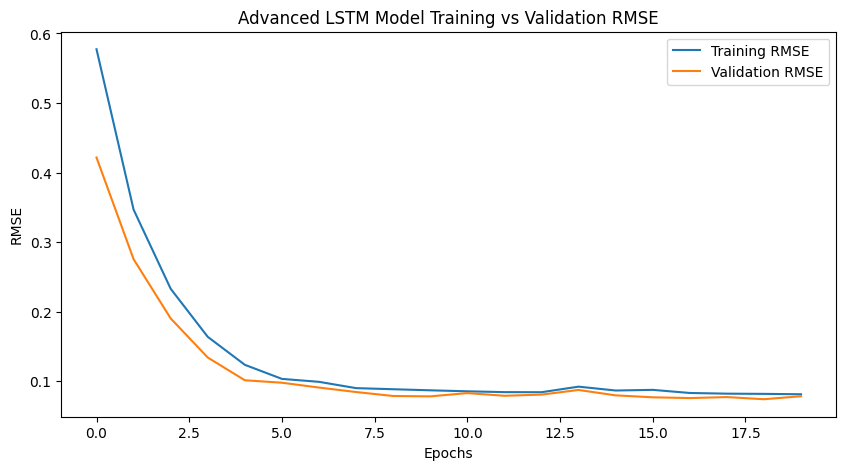

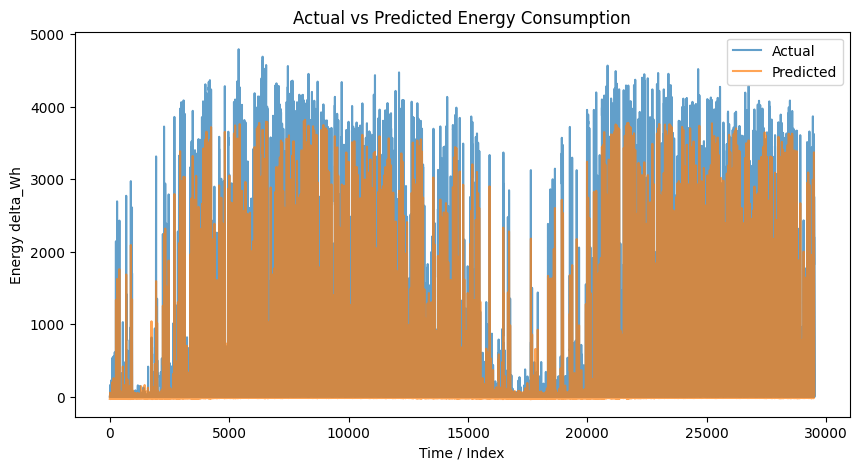

In [ ]:

# 1. Generate predictions
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 2. Inverse-transform the test target
y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

# 3. Compute metrics
mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# 4. Plot Training vs. Validation RMSE over epochs
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Advanced LSTM Model Training vs Validation RMSE")
plt.legend()
plt.show()

# 5. Plot Actual vs. Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()

## Transformer

Epoch 1/20
1076/1076 [==============================] - 389s 356ms/step - loss: 0.0464 - mae: 0.1097 - val_loss: 0.0057 - val_mae: 0.0358
Epoch 2/20
1076/1076 [==============================] - 1188s 1s/step - loss: 0.0095 - mae: 0.0516 - val_loss: 0.0061 - val_mae: 0.0385
Epoch 3/20
1076/1076 [==============================] - 387s 360ms/step - loss: 0.0082 - mae: 0.0466 - val_loss: 0.0088 - val_mae: 0.0473
Epoch 4/20
1076/1076 [==============================] - 381s 354ms/step - loss: 0.0075 - mae: 0.0450 - val_loss: 0.0045 - val_mae: 0.0347
Epoch 5/20
1076/1076 [==============================] - 384s 357ms/step - loss: 0.0072 - mae: 0.0441 - val_loss: 0.0056 - val_mae: 0.0372
Epoch 6/20
1076/1076 [==============================] - 379s 352ms/step - loss: 0.0070 - mae: 0.0437 - val_loss: 0.0046 - val_mae: 0.0321
Epoch 7/20
1076/1076 [==============================] - 368s 342ms/step - loss: 0.0066 - mae: 0.0425 - val_loss: 0.0045 - val_mae: 0.0331
Epoch 8/20
1076/1076 [==============

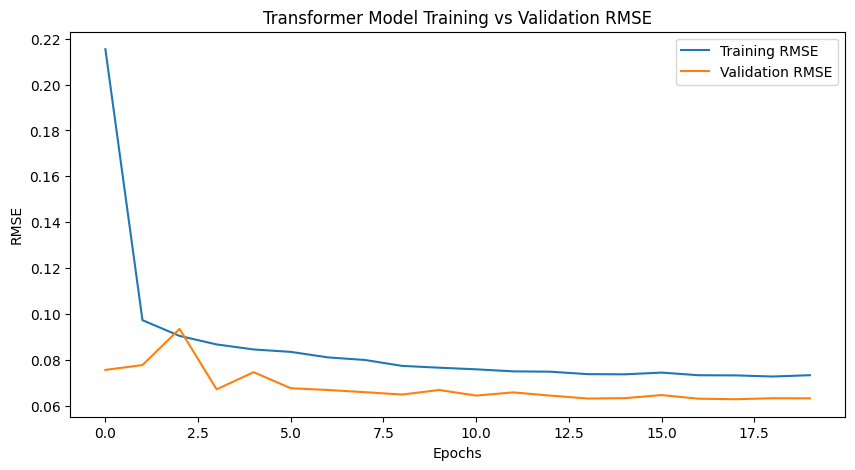

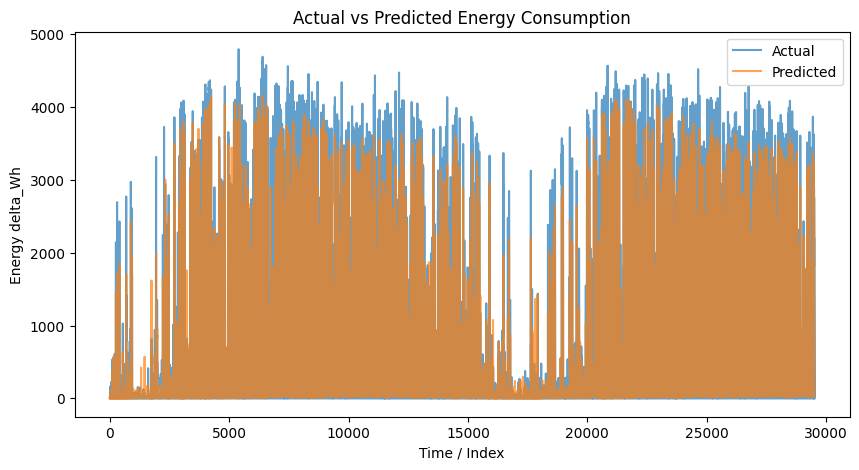

In [71]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization,
    MultiHeadAttention, Lambda
)
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


# ==============================================
# 2. POSITIONAL ENCODING
# ==============================================
def positional_encoding(time_steps, d_model):
    position = np.arange(time_steps)[:, np.newaxis]  # shape (time_steps, 1)
    div_term = np.exp(np.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
    pe = np.zeros((time_steps, d_model))
    pe[:, 0::2] = np.sin(position * div_term)
    pe[:, 1::2] = np.cos(position * div_term)
    return tf.constant(pe[np.newaxis, ...], dtype=tf.float32)  # shape (1, time_steps, d_model)

# ==============================================
# 3. TRANSFORMER ENCODER LAYER
# ==============================================
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(d_model)
        ])
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training):
        # Pre-LN Architecture
        x_norm = self.layernorm1(inputs)
        attn_output = self.att(x_norm, x_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        
        x_norm = self.layernorm2(out1)
        ffn_output = self.ffn(x_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output


# ==============================================
# 5. SET TIME_STEPS=24 EVERYWHERE
# ==============================================
d_model = 128
num_heads = 8
ff_dim = 256
dropout_rate = 0.2
num_encoder_layers = 4


# Positional encoding for 24 time steps
pe = positional_encoding(TIME_STEPS, d_model)

# ==============================================
# 6. BUILD THE MODEL
# ==============================================
inputs = Input(shape=(TIME_STEPS, X_train.shape[1]))  # shape=(24, n_features)
x = Dense(d_model)(inputs)  # Project input to d_model dimension
x = x + pe  # Add positional encoding

# Stack multiple encoder layers
for _ in range(num_encoder_layers):
    x = TransformerEncoder(d_model, num_heads, ff_dim, dropout_rate)(x)

# Use final time step output for prediction
x = Lambda(lambda x: x[:, -1, :])(x)  # extract the last time step
x = Dense(64, activation='relu')(x)
x = Dropout(dropout_rate)(x)
outputs = Dense(1)(x)

model = Model(inputs, outputs)

# ==============================================
# 7. COMPILE & TRAIN
# ==============================================
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq, y_train_seq,
    epochs=20,
    batch_size=64,
    validation_data=(X_test_seq, y_test_seq),
    callbacks=[early_stopping],
    verbose=1
)

# ==============================================
# 8. MAKE PREDICTIONS & EVALUATE
# ==============================================
y_pred_scaled = model.predict(X_test_seq)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

y_test_seq_unscaled = scaler_y.inverse_transform(y_test_seq)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

mae = mean_absolute_error(y_test_seq_unscaled, y_pred)
mse = mean_squared_error(y_test_seq_unscaled, y_pred)
rmse = root_mean_squared_error(y_test_seq_unscaled, y_pred)
from sklearn.metrics import r2_score
r2 = r2_score(y_test_seq_unscaled, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R^2:", r2)

# Plot training vs. validation RMSE
train_rmse = np.sqrt(history.history['loss'])
val_rmse = np.sqrt(history.history['val_loss'])

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Transformer Model Training vs Validation RMSE")
plt.legend()
plt.show()

# Plot Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_seq_unscaled, label='Actual', alpha=0.7)
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Time / Index')
plt.ylabel('Energy delta_Wh')
plt.title('Actual vs Predicted Energy Consumption')
plt.legend()
plt.show()
